# 1 - Multilayer Perceptron

In this practice we'll be building machine learning models (specifically, neural networks) to perform image classification using PyTorch and Torchvision. 

We'll start with one of the most basic neural network architectures, a multilayer perceptron (MLP), also known as a feedforward network. The dataset we'll be using is the famous MNIST dataset, a dataset of 28x28 black and white images consisting of handwritten digits, 0 to 9.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/mlp-mnist.png?raw=1)

We'll process the dataset, build our model and then train our model.

### Data Processing

Let's start by importing all of the modules we'll need. The main ones we need to import are:
- torch for general PyTorch functionality
- torch.nn and torch.nn.functional for neural network based functions
- torch.optim for our optimizer which will update the parameters of our neural network
- torch.utils.data for handling the dataset
- torchvision.transforms for data augmentation
- torchvision.datasets for loading the dataset
- sklearn's metrics for visualizing a confusion matrix
- sklearn's decomposition and manifold for visualizing the neural network's representations in two dimensions
- matplotlib for plotting

In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

To ensure we get reproducible results we set the random seed for Python, Numpy and PyTorch.

In [78]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

The first thing we'll do is load our dataset.

This will automatically download the training set for the MNIST dataset and save it in a folder called `.data`. It will create the folder if it does not exist.

In [79]:
ROOT = '.data'

train_data = datasets.MNIST(
  root = ROOT, 
  train = True, 
  download = True)

Next, we want to *normalize* our data. This means we want it to have a mean of zero and a standard deviation of one. 

Why do we want to do this? Normalizing our data allows our models to train faster and to also help them avoid local minima, i.e. train more reliably.

We normalize our data by subtracting the mean and dividing by the standard deviation of our dataset. First, we need to calculate the mean and standard deviation. **Note**: it is important that the mean and standard deviation are only calculated over the training set and not the test set. We do not want to use any information at all from the test set and should only look at it when we are calculating our test loss.

To calculate the means and standard deviations we get the actual data (the images) using the `.data.` attribute of our training data, convert them into floating point numbers and then use the built in `mean` and `std` functions to calculate the mean and standard deviation, respectively. The image data has values between 0-255, which we want to scale between 0-1, so we divide by 255.

In [80]:
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

In [81]:
print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624


Now we've calculated our mean and standard deviation how do we actually use them? We use Torchvision's `transforms`. 

A `transform` states how our data should be augmented and processed. Data augmentation involves manipulating the available training data in a way that artifically creates more training examples. We use `transforms.Compose` to built a list of transformations that will be applied to the image. 

The transforms we use are:

- `ToTensor()` - this converts the image from a PIL image into a PyTorch tensor.
- `Normalize` - this subtracts the mean and divides by the standard deviations given. 

The first two transformations have to be applied before `ToTensor` as they should both be applied on a PIL image. `Normalize` should only be applied to the images after they have been converted into a tensor.

In [82]:
transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean = [mean], std = [std])])

Now we have defined our transforms we can then load the train and test data with the relevant transforms defined.

In [83]:
train_data = datasets.MNIST(
  root = ROOT, 
  train = True, 
  download = True, 
  transform = transforms)

test_data = datasets.MNIST(
  root = ROOT, 
  train = False, 
  download = True, 
  transform = transforms)

We can simply check the `len` of the datasets to see how many examples are within each.

In [84]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 60000
Number of testing examples: 10000


We can get a look at some of the images within our dataset to see what we're working with. The function below plots a square grid of images. If you supply less than a complete square number of images it will ignore the last few.

In [85]:
def plot_images(images):
  n_images = len(images)

  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))

  fig = plt.figure()
  for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap = 'bone')
    ax.axis('off')

Let's load 25 images. These will have been processed through our transforms.

It's good practice to see your data with your transforms applied so you can ensure they look sensible.

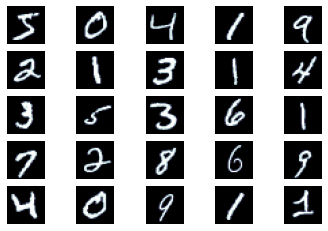

In [86]:
N_IMAGES = 25
images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]] 
plot_images(images)

The MNIST dataset comes with a training and test set, but not a validation set. We want to use a validation set to check how well our model performs on unseen data. Why don't we just use the test data? We should only be measuring our performance over the test set once, after all training is done. We can think of the validation set as a proxy test set we are allowed to look at as much as we want. 

We create a validation set taking 10% of the training set. **Note:** the validation set should always be created from the training set. Never take the validation set from the test set. When researchers publish research papers they should be comparing performance across the test set and the only way to ensure this is a fair comparison is for all researchers to use the same test set. If the validation set is taken from the test set, then the test set is not the same as everyone else's and the results cannot be compared against each other.

First, we have to define the exact number of examples that we want to be in each split of the training/validation sets.

In [87]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

Then, we use the `random_split` function to take a random 10% of the training set to use as a validation set. The remaining 90% will stay as the training set.

In [88]:
train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

We can print out the number of examples again to check our splits are correct.

In [89]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


Next, we'll define a `DataLoader` for each of the training/validation/test sets. We can iterate over these and they will yield batches of images and labels which we can use to train our model.

We only need to shuffle our training set as it will be used for stochastic gradient descent and we want each batch to be different between epochs. As we aren't using the validation or test sets to update our model parameters they do not need to be shuffled.

Ideally, we want to use the biggest batch size that we can. The 64 here is relatively small and can be increased if our hardware can handle it.

In [90]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, shuffle = True, batch_size = BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data, batch_size = BATCH_SIZE)
test_iterator = data.DataLoader(test_data, batch_size = BATCH_SIZE)

### Defining the Model

Our model will be a neural network, specifically a multilayer perceptron (MLP) with two hidden layers. The image below shows the archicture of the model. 

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/mlp-mnist.png?raw=1)

Specifically, first we will flatten our 1x28x28 (1 color channel, 28 pixels height and width) image into a 784 element vector, also called 784 *features*. We flatten our input as MLPs cannot handle two or three dimensional data. Next, the 784 dimensional input is passed through the first hidden layer to transform it into 250 dimensions. Then, another hidden layer, which will transform it to 100 dimensions. Finally, an output layer which will transform it into a 10 dimensional vector. The output dimension should equal the number of classes within your data. Here we have ten digits, 0 - 9, so need our output to be 10 dimensions.

The transformation between 784 to 250, 250 to 100 and 100 to 10 dimensions are done by `Linear` layers. These are also known as fully connected or affine layers. In these layers every element in one layer is connected to every element in the next. We can think of these elements as *neurons* as this architecture is inspired by how the human brain is made of millions of interconnected nodes, also called neurons. 

Each connection between a neuron in one layer and a neuron in the next has a *weight* associated with it. The input to one neuron is sum of the weighted values of all neurons in the previous layer connected to it, plus a weighted bias term, where the bias value is always 1. The neuron then applies an *activation function* to this weighted sum. This activation function is a non-linear function that allows the neural network to learn non-linear functions between inputs and outputs. 

We define our MLP below, which consists of three linear layers. We first take the input batch of images and flatten them so they can be passed into the linear layers. We then pass them through the first linear layer, `input_fc`, which calculates the weighted sum of the inputs, and then apply the *ReLU* (rectified linear unit) activation function elementwise. This result is then passed through another linear layer, `hidden_fc`, again applying the same activation function elementwise. Finally, we pass this through the final linear layer, `output_fc`. We return not only the output but also the second hidden layer as we will do some analysis on it later.

The ReLU activation function is a popular non-linear function that is simply $max(0, x)$, where $x$ is the weighted sum of the inputs to that neuron. Other activation functions used are hyperbolic tan (tanh) and sigmoid function, however ReLU is the most commonly used.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/relu.png?raw=1)


One thing to note is that we do not use an activation function on the input directly or on the output. You should never use activation functions directly on the input, i.e. `F.relu(x)`. PyTorch combines activation functions to be applied on the output with the functions which calculate the *loss*, also known as *error* or *cost*, of a neural network. This is done for numerical stability.

Why did we choose hidden dimensions of 250 and 100 elements? Why did we only have two hidden layers? There is no magic formula to tell us how many layers to use and how many neurons to have in each layer and there is most probably a better set of values. However, the general idea is that neural networks extract features from data. Layers closer to the input learn to extract general features (e.g. lines, curves, edges), whilst later layers combine the features extracted from the previous layer into more high level features (e.g. the intersection of two lines making a cross, multiple curves make a circle). We force our neural network to learn these features by reducing the number of neurons in each layer. This way it has to learn to compress information by extracting only the useful and general features. Thus, we want a neural network with multiple layers and some sort of information compression (reduced number of neurons in subsequent layers).

In [91]:
class MLP(nn.Module): # MLP = Multi Layer Perceptron
  def __init__(self, input_dim, output_dim):
    super().__init__()
    # you have to define the functions which are needed to build our network, we will use the function Linear from nn (https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
    # Linear = fully connected
    self.input_fc = nn.Linear(input_dim, 250)
    self.hidden_fc = nn.Linear(250, 100)
    self.output_fc = nn.Linear(100, output_dim)


  def forward(self, x):
      # In here we will build the forward path of our network
      # x shape is [batch_size, dim1, dim2, ...]
      batch_size = x.shape[0]

      # Reshape the input (you can use the view method of a tensor ) (https://pytorch.org/docs/stable/tensors.html#initializing-and-basic-operations)
      # x shape is [batch size, height * width]
      x = x.view(batch_size, -1)

      # Define first layer h_1 (use self.input_fc function with relu (https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html))
      # torch.nn.ReLU = F.relu. Difference between the nn and F library that is in nn there are mostly classes, while in F mostly functions
      # h_1 shape is [batch size, 250]
      h_1 = F.relu(self.input_fc(x))

      # Define second layer h_2 (use self.hidden_fc function with relu)
      # h_2 shape is [batch size, 100]
      h_2 = F.relu(self.hidden_fc(h_1))

      # Define last layer y_pred (use self.output_fc function)
      # y_pred = [batch size, output dim]
      y_pred = self.output_fc(h_2)
      
      return y_pred, h_2

We'll define our model by creating an instance of it and setting the correct input and output dimensions.

In [92]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

# 1. create an instance of the MLP class and call it model
model = MLP(INPUT_DIM, OUTPUT_DIM)

We can also create a small function to calculate the number of trainable parameters (weights and biases) in our model - in case all of our parameters are trainable.

In [93]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

The first layer has 784 neurons connected to 250 neurons, so 784*250 weighted connections plus 250 bias terms.

The second layer has 250 neurons connected to 100 neurons, 250*100 weighted connections plus 100 bias terms.

The third layer has 100 neurons connected to 10 neurons, 100*10 weighted connections plus 10 bias terms.

$$784 \cdot 250 + 250 + 250 \cdot 100 + 100 + 100 \cdot 10 + 10 = 222,360 $$

In [94]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 222,360 trainable parameters


### Training the Model

Next, we'll define our optimizer. This is the algorithm we will use to update the parameters of our model with respect to the loss calculated on the data.

We aren't going to go into too much detail on how neural networks are trained here in the practice but the gist of it is:
- pass a batch of data through your model
- calculate the loss of your batch by comparing your model's predictions against the actual labels
- calculate the gradient of each of your parameters with respect to the loss
- update each of your parameters by subtracting their gradient multiplied by a small *learning rate* parameter

We use the *Adam* algorithm with the default parameters to update our model. Improved results could be obtained by searching over different optimizers and learning rates, however default Adam is usually a good starting off point. We will dive into the most important optimization algorithms in future practices.

In [95]:
# define an optimizer (https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, dampening=0, weight_decay=0.0001, nesterov=True)

Then, we define a *criterion*, PyTorch's name for a loss/cost/error function. This function will take in your model's predictions with the actual labels and then compute the loss/cost/error of your model with its current parameters.

`CrossEntropyLoss` both computes the *softmax* activation function on the supplied predictions as well as the actual loss via *negative log likelihood*. 

Briefly, the softmax function is:

$$\text{softmax }(\mathbf{x}) = \frac{e^{x_i}}{\sum_j e^{x_j}}$$ 

This turns out 10 dimensional output, where each element is an unbounded real number, into a probability distribution over 10 elements. That is, all values are between 0 and 1, and together they all sum to 1. 

Why do we turn things into a probability distribution? So we can use negative log likelihood for our loss function as it expects probabilities. PyTorch calculates negative log likelihood for a single example via:

$$\text{negative log likelihood }(\mathbf{\hat{y}}, y) = -\log \big( \text{softmax}(\mathbf{\hat{y}})[y] \big)$$

$\mathbf{\hat{y}}$ is the $\mathbb{R}^{10}$ output, from our neural network, whereas $y$ is the label, an integer representing the class. The loss is the negative log of the class index of the softmax. For example:

$$\mathbf{\hat{y}} = [5,1,1,1,1,1,1,1,1,1]$$

$$\text{softmax }(\mathbf{\hat{y}}) = [0.8585, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157]$$

If the label was class zero, the loss would be:

$$\text{negative log likelihood }(\mathbf{\hat{y}}, 0) = - \log(0.8585) = 0.153 \dots$$

If the label was class five, the loss would be:

$$\text{negative log likelihood }(\mathbf{\hat{y}}, 5) = - \log(0.0157) = 4.154 \dots$$

So, intuitively, as your model's output corresponding to the correct class index increases your loss decreases.

In [96]:
#define the criterion (https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
criterion = nn.CrossEntropyLoss() 

We then define `device`. This is used to place your model and data on to a GPU, if you have one.

In [97]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

We place our model and criterion on to the device by using the `.to` method.

In [98]:
# convert the model and the criterion to the device
model.to(device)
criterion.to(device)

CrossEntropyLoss()

Next, we'll define a function to calculate the accuracy of our model. This takes the index of the highest value for your prediction and compares it against the actual class label. We then divide how many our model got correct by the amount in the batch to calculate accuracy across the batch.

In [99]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

We finally define our training loop.

Tasks:
1.  put our model into `train` mode
2.  iterate over our dataloader, returning batches of (image, label)
3.  place the batch on to our GPU, if we have one
4.  clear the gradients calculated from the last batch
5.  pass our batch of images, `x`, through to model to get predictions, `y_pred`
6.  calculate the loss between our predictions and the actual labels
7.  calculate the accuracy between our predictions and the actual labels
8.  calculate the gradients of each parameter
9.  update the parameters by taking an optimizer step
10. update our metrics

Some layers act differently when training and evaluating the model that contains them, hence why we must tell our model we are in "training" mode. The model we are using here does not use any of those layers, however it is good practice to get used to putting your model in training mode.

In [100]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss_sum = 0
  epoch_acc_sum = 0

  losses = []
  accuracies = []
  
  model.train()

  #iterate over our data loader
  for (x, y) in iterator: # shape(x) = [batch_size, x1_dim, x2_dim], shape(y) = [batch_size, y1_dim]
    #3. use .to method
    x.to(device)
    y.to(device)

    #4. use zero_grad method of the optimizer
    optimizer.zero_grad()

    #5. use your model to pass the batch
    prediction, _ = model(x)

    #6. use the criterion to claculate the loss
    loss = criterion(prediction, y)
    
    #7. use calculate_accuracy function
    acc = calculate_accuracy(prediction, y)
    
    #8. use backward method of the loss
    loss.backward()

    #9. use step method of the optimizer
    optimizer.step()

    epoch_loss_sum += loss.item() # loss.item(): loss in batch
    epoch_acc_sum += acc.item() # acc.item(): accuracy in batch

    losses.append(loss.item())
    accuracies.append(acc.item())
    
  epoch_loss = epoch_loss_sum / len(iterator) # avarage epoch_loss; len(iterator): number of batches
  epoch_acc = epoch_acc_sum / len(iterator) # avarage epoch_acc
  
  return epoch_loss, epoch_acc, losses, accuracies

The evaluation loop is similar to the training loop. The differences are:
- we put our model into evaluation mode with `model.eval()`
- we wrap the iterations inside a `with torch.no_grad()`
- we do not zero gradients as we are not calculating any
- we do not calculate gradients as we are not updating parameters
- we do not take an optimizer step as we are not calculating gradients

`torch.no_grad()` ensures that gradients are not calculated for whatever is inside the `with` block. As our model will not have to calculate gradients it will be faster and use less memory. 

In [101]:
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0
  
  model.eval()
  
  with torch.no_grad():
    for (x, y) in iterator:
      #1. put the inputs in device: use .to method
      x.to(device)
      y.to(device)

      #2. calculate prediciton: use your model to pass the batch 
      prediction, _ = model(x)

      #3. claculate the loss: use the criterion
      loss = criterion(prediction, y)

      #4. calculate accuracy: use calculate_accuracy function
      acc = calculate_accuracy(prediction, y)
        
      #5. update our metrics
      epoch_loss += loss.item()
      epoch_acc += acc.item()
      
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

The final step before training is to define a small function to tell us how long an epoch took.

In [102]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We're finally ready to train!

During each epoch we calculate the training loss and accuracy, followed by the validation loss and accuracy. We then check if the validation loss achieved is the best validation loss we have seen. If so, we save our model's parameters (called a `state_dict`).

In [103]:
all_train_losses = []
all_train_accuracies = []

EPOCHS = 10
best_epoch_valid_loss = float('inf')
for epoch in range(EPOCHS):
  start_time = time.monotonic()
  #tasks
  #1. calculate train_loss, train_acc, batch_losses, batch_accuracies in the epoch for statistics (use the train function)
  epoch_train_loss, epoch_train_acc, batch_losses, batch_accuracies = train(model, train_iterator, optimizer, criterion, device)
  all_train_losses.extend(batch_losses)
  all_train_accuracies.extend(batch_accuracies)

  #2. calculate valid_loss, valid_acc (use the evaluate funciton)
  epoch_valid_loss, epoch_valid_acc = evaluate(model, valid_iterator, criterion, device)

  if epoch_valid_loss < best_epoch_valid_loss:
    best_epoch_valid_loss = epoch_valid_loss
    #3. save the model with the path 'tut1-model.pt' (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
    torch.save(model.state_dict(), "tut1-model.pt")
  
  end_time = time.monotonic()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {epoch_train_loss:.3f} | Train Acc: {epoch_train_acc*100:.2f}%')
  print(f'\t Val. Loss: {epoch_valid_loss:.3f} |  Val. Acc: {epoch_valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 12s
	Train Loss: 0.246 | Train Acc: 92.61%
	 Val. Loss: 0.148 |  Val. Acc: 95.25%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.100 | Train Acc: 96.91%
	 Val. Loss: 0.121 |  Val. Acc: 96.46%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.067 | Train Acc: 97.92%
	 Val. Loss: 0.105 |  Val. Acc: 96.94%
Epoch: 04 | Epoch Time: 0m 11s
	Train Loss: 0.052 | Train Acc: 98.32%
	 Val. Loss: 0.088 |  Val. Acc: 97.38%
Epoch: 05 | Epoch Time: 0m 11s
	Train Loss: 0.040 | Train Acc: 98.73%
	 Val. Loss: 0.095 |  Val. Acc: 97.41%
Epoch: 06 | Epoch Time: 0m 11s
	Train Loss: 0.035 | Train Acc: 98.80%
	 Val. Loss: 0.092 |  Val. Acc: 97.55%
Epoch: 07 | Epoch Time: 0m 11s
	Train Loss: 0.029 | Train Acc: 99.04%
	 Val. Loss: 0.093 |  Val. Acc: 97.66%
Epoch: 08 | Epoch Time: 0m 11s
	Train Loss: 0.027 | Train Acc: 99.05%
	 Val. Loss: 0.118 |  Val. Acc: 97.45%
Epoch: 09 | Epoch Time: 0m 11s
	Train Loss: 0.022 | Train Acc: 99.27%
	 Val. Loss: 0.126 |  Val. Acc: 96.96%
Epoch: 10 | Epoch T

Afterwards, we load the parameters of the model that achieved the best validation loss and then use this to evaluate our model on the test set.

In [104]:
#task: load the best model with the path 'tut1-model.pt' (use load_state_dict method of the model)
model.load_state_dict(torch.load('tut1-model.pt'))

#task: evaluate the best model (calculate test_loss, test_acc using evaluatoin function)
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

Our model achieves 98% accuracy on the test set.

This can be improved by tweaking hyperparameters, e.g. number of layers, number of neurons per layer, optimization algorithm used, learning rate, etc. 

In [105]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.074 | Test Acc: 97.65%


In [106]:
import matplotlib.pyplot as plt

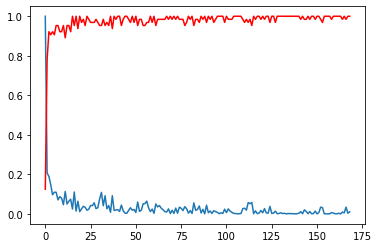

In [108]:
plt.plot(all_train_losses[0::50]/np.max(all_train_losses))
plt.plot(all_train_accuracies[0::50]/np.max(all_train_accuracies),'r')

### Conclusions

In this notebook we have shown: 
- loading Torchvision datasets
- loading transforms to normalize our data
- defining a MLP
- training a model to achieve >97% accuracy

In the next practice we'll implement a convolutional neural network (CNN) and evaluate it on the MNIST dataset.